In [2]:

import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from optimal_interpolation import OImerge
import calendar
import auxiliary as au
from auxiliary_merge import *


########################################################################################################################

# basic settings
# y1 = int(sys.argv[3])
# y2 = int(sys.argv[4])
# year = [y1, y2]
year = [1980, 1980]
weightmode = 'RMSE'
vars = ['prcp', 'tmean', 'trange']

# "Gaussian": prcp will be transformed into normal distributions; "Actual": actual space
# "Gaussian" is not a good choice because station prcp regression using box-cox has large underestimation
prcp_space = 'Actual'

hwsize = 2  # 5X5 space window used to support estimation at the center grid
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)

# output path of OImerged data
path_oimerge = '/Users/localuser/GMET/merge'
# path_oimerge = '/home/gut428/OImerge'

# path of merged reanalysis data
path_bac = '/Users/localuser/GMET/merge'
path_bac_stn = '/Users/localuser/Research/Test'
# path_bac = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/Reanalysis_merge'
# path_bac_stn = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/CrossValidate_2layer'
file_corrmerge_stn = [''] * len(vars)
for i in range(len(vars)):
    file_corrmerge_stn[i] = path_bac_stn + '/mergecorr_' + vars[i] + '_' + weightmode + '.npz'

# path of regressed observations
# path_obs = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout'
path_obs = '/Users/localuser/GMET/merge'

# the near stations of each station
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
near_file_GMET = '/Users/localuser/GMET/pyGMET_NA/weight_nearstn.npz'

# mask file
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
file_mask = './DEM/NA_DEM_010deg_trim.mat'

# FileStnInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
FileStnInfo = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt' 
########################################################################################################################

# basic processing
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
nrows, ncols = np.shape(mask)

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# stninfo
stnID, stninfo = au.readstnlist(FileStnInfo)
nstn = len(stnID)

/Users/localuser/Github/PyGMET/auxiliary.py:13: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(FileStnInfo, delimiter=',', dtype=None, skip_header=2)


In [3]:
datatemp = np.load(file_corrmerge_stn[0])
reacorr_stn_all = datatemp['reacorr_stn']
reanum, nstn, ntimes = np.shape(reacorr_stn_all)
del datatemp, reacorr_stn_all

# find nearby grids for each station
nearrowcol = np.zeros([nstn, 2], dtype=int)
for i in range(nstn):
    rowi = np.argmin(abs(lattar-stninfo[i, 1]))
    coli = np.argmin(abs(lontar-stninfo[i, 2]))
    nearrowcol[i, 0] = rowi
    nearrowcol[i, 1] = coli

In [8]:
v=0
y=1980
m=0


In [6]:
    print('OI merge at stations:', vars[v])
    filemerge_stn = path_oimerge + '/OImerge_stn_' + vars[v] + '_neargrid.npz'
#     if os.path.isfile(filemerge_stn):
#         continue

    # load corrected/merged reanalysis data at all station points (those are totally independent with station observations)
    datatemp = np.load(file_corrmerge_stn[v])
    reamerge_stn_all = datatemp['reamerge_stn']
    reacorr_stn_all = datatemp['reacorr_stn']
    reanum, nstn, ntimes = np.shape(reacorr_stn_all)
    del datatemp

    oimerge_stn = np.zeros([nstn, ntimes])

OI merge at stations: prcp


In [9]:
            print('merging error: date:', y * 100 + m + 1)
            indym = (date_number['yyyy'] == y) & (date_number['mm'] == m + 1)
            nday = sum(indym)
            oimerge_stnym = np.zeros([nstn, nday])

            # load station regression estimates at all stations (locally weighted regression)
            date_cal_start = y * 10000 + (m + 1) * 100 + 1
            date_cal_end = y * 10000 + (m + 1) * 100 + calendar.monthrange(y, m + 1)[1]
            datestr = str(date_cal_start) + '-' + str(date_cal_end)
            file1 = path_obs + '/stndata_' + datestr + '.npz'
            datatemp1 = np.load(file1)
            observation_stn = datatemp1[vars[v] + '_stn_daily']



            file_bac = path_bac + '/mergedata_' + vars[v] + '_' + str(y * 100 + m + 1) + weightmode + '.npz'
            file_obs = path_obs + '/output_' + datestr + '.npz'
            file_obserr = path_obs + '/output_realerror_' + datestr + '.npz'


            # get the best reanalysis among three original reanalysis datasets and one merged dataset for each station
            reamerge_stn = reamerge_stn_all[:, indym]
            reacorr_stn = reacorr_stn_all[:, :, indym]
            rearmse = np.zeros([nstn, reanum+1])
            rearmse[:, 0] = calmetric(reamerge_stn, observation_stn, metname='RMSE')
            for i in range(3):
                rearmse[:, i + 1] = calmetric(reacorr_stn[i, :, :], observation_stn, metname='RMSE')
            bestchoice = np.argmin(rearmse, axis=1)
            reafinal_stn = reamerge_stn.copy()
            for i in range(nstn):
                if bestchoice[i] > 0:
                    reafinal_stn[i, :] = reacorr_stn[bestchoice[i] - 1, i, :]

            # load background data (value and error)
            datatemp = np.load(file_bac)
            v_bac = datatemp['merge_data']
            if vars[v] == 'tmean' or vars[v] == 'trange':
                e_bac = datatemp['merge_error_raw']  # error in actual space
            elif vars[v] == 'prcp':
                if prcp_space == 'Actual':
                    e_bac = datatemp['merge_error_raw']
                elif prcp_space == 'Gaussian':
                    if weightmode == 'BMA':
                        e_bac = datatemp['merge_error_bc']
                        v_bac = box_cox_transform(v_bac)
                    elif weightmode == 'RMSE':
                        e_bac = datatemp['merge_error_raw']
                        truth = v_bac - e_bac
                        v_bac = box_cox_transform(v_bac)
                        e_bac = v_bac - box_cox_transform(truth)
            else:
                sys.exit('Unknown variable')
            del datatemp


            # load observation data (value and error)
            datatemp = np.load(file_obs)
            datatemp2 = np.load(file_obserr)
            if vars[v] == 'tmean' or vars[v] == 'trange':
                v_obs = datatemp[vars[v]]
                # e_obs = datatemp[var + '_err']
                e_obs = datatemp2[vars[v] + '_realerr']
            elif vars[v] == 'prcp':
                if prcp_space == 'Actual':
                    v_obs = datatemp['pcp_raw']
                    # e_obs = datatemp['pcp_err_raw']
                    e_obs = datatemp2['pcp_realerr_raw']
                elif prcp_space == 'Gaussian':
                    v_obs = datatemp['pcp_bc']
                    # e_obs = datatemp['pcp_err_bc']
                    e_obs = datatemp2['pcp_realerr_bc']
            else:
                sys.exit('Unknown variable')
            del datatemp
            v_obs = np.flipud(v_obs)
            e_obs = np.flipud(e_obs)

merging error: date: 198001


In [77]:
i=1300

In [78]:
                    b_tar = reafinal_stn[i, :]
                    tar_err_b = b_tar - observation_stn[i, :]

                    b_near = v_bac[nearrowcol[i, 0]-hwsize:nearrowcol[i, 0]+hwsize+1,
                             nearrowcol[i, 1]-hwsize:nearrowcol[i, 1]+hwsize+1, :]
                    o_near = v_obs[nearrowcol[i, 0]-hwsize:nearrowcol[i, 0]+hwsize+1,
                             nearrowcol[i, 1]-hwsize:nearrowcol[i, 1]+hwsize+1, :]
                    near_err_b = e_bac[nearrowcol[i, 0]-hwsize:nearrowcol[i, 0]+hwsize+1,
                             nearrowcol[i, 1]-hwsize:nearrowcol[i, 1]+hwsize+1, :]
                    near_err_o = e_obs[nearrowcol[i, 0]-hwsize:nearrowcol[i, 0]+hwsize+1,
                             nearrowcol[i, 1]-hwsize:nearrowcol[i, 1]+hwsize+1, :]
                    b_near[hwsize, hwsize, :] = np.nan
                    o_near[hwsize, hwsize, :] = np.nan
                    near_err_b[hwsize, hwsize, :] = np.nan
                    near_err_o[hwsize, hwsize, :] = np.nan
                    snum=(hwsize*2+1)**2
                    b_near=np.reshape(b_near,[snum, nday])
                    o_near = np.reshape(o_near, [snum, nday])
                    near_err_b = np.reshape(near_err_b, [snum, nday])
                    near_err_o = np.reshape(near_err_o, [snum, nday])
                    indnan = ~np.isnan(b_near[:,0])
                    b_near=b_near[indnan,:]
                    o_near = o_near[indnan, :]
                    near_err_b = near_err_b[indnan, :]
                    near_err_o = near_err_o[indnan, :]

                    weight = OImerge(tar_err_b, near_err_b, near_err_o)
                    if np.any(np.isnan(weight)) or np.any(abs(weight) > 2):
                        weight = np.ones(len(weight)) / len(weight)

                    diff = o_near - b_near
                    merge_est = b_tar.copy()
                    for id in range(nday):
                        merge_est[id] = merge_est[id] + np.dot(weight, diff[:, id])

In [79]:
print(au.metric(observation_stn[i,:], merge_est))
print(weight)
d11=diff[:,10]

[ 0.86661642 -0.06681965  0.71367169  1.39419014]
[0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]


In [64]:
            # load station regression estimates at all stations (locally weighted regression)
            date_cal_start = y * 10000 + (m + 1) * 100 + 1
            date_cal_end = y * 10000 + (m + 1) * 100 + calendar.monthrange(y, m + 1)[1]
            datestr = str(date_cal_start) + '-' + str(date_cal_end)
            file1 = path_obs + '/stndata_' + datestr + '.npz'
            file2 = path_obs + '/error_' + datestr + '.npz'
            datatemp1 = np.load(file1)
            datatemp2 = np.load(file2)
            observation_stn = datatemp1[vars[v] + '_stn_daily']
            if vars[v] == 'prcp':
                regression_stn = observation_stn + datatemp2['pcp' + '_err_stn_raw']
            else:
                regression_stn = observation_stn + datatemp2[vars[v] + '_err_stn']
            del datatemp1, datatemp2

In [18]:
    # load near station information
    datatemp = np.load(near_file_GMET)
    if vars[v] == 'prcp':
        near_loc = datatemp['near_stn_prcpLoc']
        near_weight = datatemp['near_stn_prcpWeight']
    else:
        near_loc = datatemp['near_stn_tempLoc']
        near_weight = datatemp['near_stn_tempWeight']
    del datatemp

In [80]:
                    near_loci = near_loc[i, :]
                    near_loci = near_loci[near_loci > -1]
                    if len(near_loci) > (hwsize * 2 + 1) ** 2:
                        near_loci = near_loci[0:(hwsize * 2 + 1) ** 2]
                    b_tar = reafinal_stn[i, :]
                    o_tar = regression_stn[i, :]
                    b_near = reafinal_stn[near_loci, :]
                    o_near = regression_stn[near_loci, :]

                    tar_err_b = b_tar - observation_stn[i, :]
                    near_err_b = b_near - observation_stn[near_loci, :]
                    near_err_o = o_near - observation_stn[near_loci, :]
                    weight = OImerge(tar_err_b, near_err_b, near_err_o)
                    if np.any(np.isnan(weight)) or np.any(abs(weight) > 2):
                        weight = near_weight[i, 0:len(near_loci)]
                        weight = weight / np.sum(weight)

                    diff = o_near - b_near
                    merge_est = b_tar.copy()
                    for id in range(nday):
                        merge_est[id] = merge_est[id] + np.dot(weight, diff[:, id])

In [81]:
print(au.metric(observation_stn[i,:], merge_est))
print(weight)
d22=diff[:,10]

[ 0.94491008 -0.0802062   0.60210103  1.04854957]
[-0.01557363 -0.03427934 -0.1030594   0.08670482  0.03128679 -0.13013183
  0.08796956 -0.0348684   0.03329572 -0.04144519 -0.01360227  0.11623106
  0.01057448  0.00464872 -0.02028544  0.02232799 -0.09087883 -0.00513483
  0.00429572 -0.00275641 -0.07879999  0.09190813 -0.1738552   0.02708706
 -0.00850936]


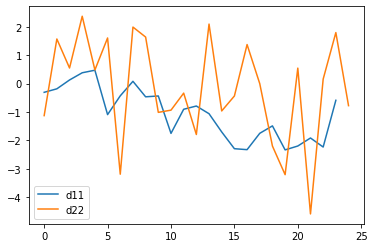

In [52]:
plt.plot(d11)
plt.plot(d22)
plt.legend(['d11','d22'])

In [72]:
def OImerge(tar_err_b, near_err_b, near_err_o):
    # tar/near: target and nearby stations/grids
    # o/b: observation/background
    # err: error (o-t or b-t where t is truth)
    # row: models, col: time steps
    # calculate weight (W) using: W(Cb + Co)=Cb0
    if np.ndim(near_err_b)==1:
        near_err_b=near_err_b[np.newaxis,:]
    nstn, ntimes = np.shape(near_err_b)
    # covariance matrix of errors
    Cb = np.cov(near_err_b)
    Co = np.cov(near_err_o)
    Co = np.eye(nstn) * Co # independence assumption
    Cb0 = np.zeros(nstn)
    for i in range(nstn):
        Cb0[i] = cov1d(tar_err_b, near_err_b[i,:])

    try:
        cbot = np.linalg.inv(Cb+Co)
        W = np.dot(Cb0, cbot)
    except:
        # singular matrix
        W = np.nan * np.ones(nstn)
    return W

def cov1d(a, b):
    if len(a) != len(b):
        return
    a_mean = np.mean(a)
    b_mean = np.mean(b)

    sum = 0

    for i in range(0, len(a)):
        sum += ((a[i] - a_mean) * (b[i] - b_mean))

    return sum/(len(a)-1)